# Fastpages Notebook Blog Post
> How to use Captum.ai to intepret an image classification model.

- toc: true
- badges: true
- comments: true
- categories: [jupyter]


[Captum](https://captum.ai/) (translates to *comprehension* in Latin) is an open source library for model interpretability. It helps model developers understand which features are contributing to their model’s output.
It implements state-of-the-art interpretability algorithms in PyTorch, and provide them as an easy to use API.

The rest of this notebook illustrates how to use this library to interpret a fastai v2 based image classification model.

## Setup

In [0]:
%%capture
%%bash
pip install fastai2
pip install psutil
pip install captum

In [0]:
from matplotlib.colors import LinearSegmentedColormap

from fastai2.vision.all import *

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## Data
Download data for training an image classification model

In [0]:
path = untar_data(URLs.PETS)/'images'

imgs = get_image_files(path)

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, imgs, valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

## Model
Fine tune an Imagenet-based model on the new images dataset.

In [0]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.169865,0.020558,0.004736,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.060073,0.026544,0.008119,00:24


Basic interpertation of the model prediected classes vs. actual ones.

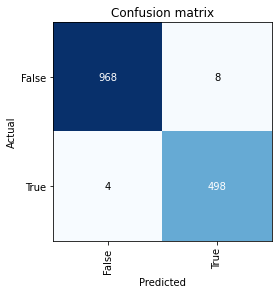

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Visualize top losses, e.g. to check if the images themselves are correctly annotated.

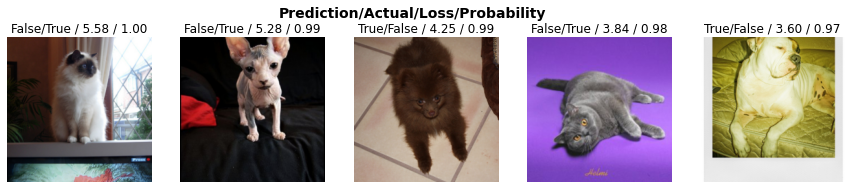

In [0]:
interp.plot_top_losses(5, nrows=1)

Store/Restore the fine tuned model

In [0]:
learn.export('/tmp/model.pkl')
learn_inf = load_learner('/tmp/model.pkl')

Select a random image and plot it

In [0]:
idx = random.randint(0, len(imgs))

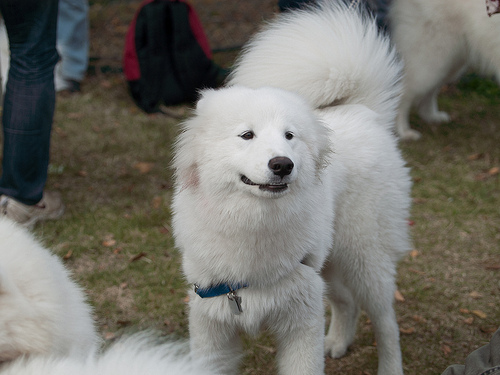

In [0]:
image = PILImage.create(imgs[idx])
image

In [0]:
image = learn_inf.dls.after_item(image)
image = learn_inf.dls.after_batch(image)

In [0]:
pred,pred_idx,probs = learn_inf.predict(imgs[idx])
pred, pred_idx, probs

('False', tensor(0), tensor([9.9998e-01, 2.0485e-05]))

## Interpretability
Let's use Captum.ai to interpret the model predictions and to have a visual on where the network focused more in the input image.

### Gradient-based attribution
Integrated Gradients is an interpretaility technique based on the approximation of integral gradients. The basic implementation works as followss:
* Given as input target image and a baseline image (usually a black image), generate multiple images between both starting from darker to lighter.
* Do forward pass with each of those images to predict a class and calculate the gradient.
* Approximate the integral of the gradients of all those images

The following example, illustrates how to use Captum `IntegratedGradients` to compute the attributions using Integrated Gradients and visualize them on the target image.

In [0]:
integrated_gradients = IntegratedGradients(learn_inf.model)
attr_ig = integrated_gradients.attribute(image, target=pred_idx, n_steps=200)

In [0]:
transposed_attr_ig = np.transpose(attr_ig.squeeze().numpy(), (1,2,0))
transposed_image = np.transpose(image.squeeze().numpy(), (1,2,0))

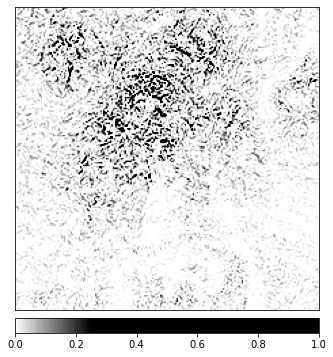

In [0]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(transposed_attr_ig,
                             transposed_image,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

For a better visual of the attribution, the images between baseline and target are sampled using a noise tunnel (by adding gaussian noise). And when the gradients are calulcated, we smoothe them by calculating their mean squared.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


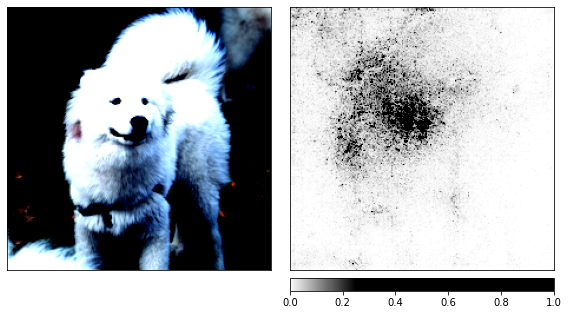

In [0]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(image, n_samples=10, nt_type='smoothgrad_sq', target=pred_idx)
transposed_attr_ig_nt = np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_ig_nt,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution
Occlusion-based attribution is a different interepretation technique based on perturbing parts of the original image (e.g. by zeroing) and computing how this affects the model decision.
This technique is implemented by:
* Slide a window of shape (h, w) on the target image with a stride s
* Replace the window with a baseline (e.g. with black) and qunatify the effect on model decision.
* Repeat previous steps until all of the target image is covered. 

Simiarly to convolution, this technique can become very slow when used in large models and large input images.

As a first exercise, we run a sliding window of size 15x15 and a stride of 8 along both image dimensions. For each window, we occlude the image with a baseline value of 0.

In [0]:
occlusion = Occlusion(learn_inf.model)

attr_occ = occlusion.attribute(image,
                               strides = (3, 8, 8),
                               target=pred_idx,
                               sliding_window_shapes=(3,15, 15),
                               baselines=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


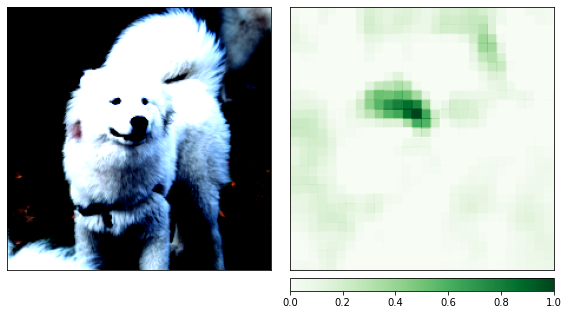

In [0]:
_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.squeeze().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

Let's try different window shape and sliding window and visuzalize the result, by rescaling back to the shape of the original image.

Experimenting with different windows is important because:
* Different shape may lead to a significaly different result.
* Larger windows is useful when the input image presents some local coherence.


In this case, we run a sliding window of size 60x60 and a stride of 50 along both image dimensions. For each window, we occlude the image with a baseline value of 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


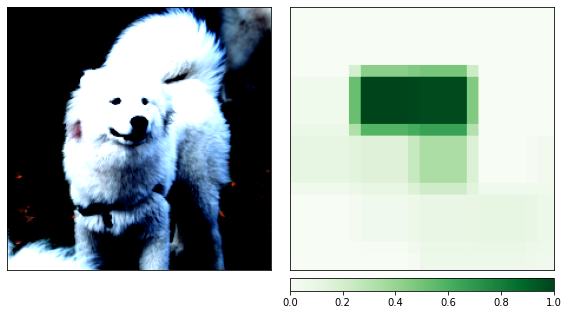

In [0]:
occlusion = Occlusion(learn_inf.model)

attr_occ = occlusion.attribute(image,
                               strides = (3, 50, 50),
                               target=pred_idx,
                               sliding_window_shapes=(3,60, 60),
                               baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.squeeze().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## References
- Axiomatic Attribution for Deep Networks - [link](https://arxiv.org/abs/1703.01365)
- Towards better understanding of gradient-based attribution methods for Deep Neural Networks - [link](https://arxiv.org/abs/1711.06104)